### Using Tree data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import *
import seaborn as sns
from tqdm.notebook import tqdm

dendro = pd.read_feather("../data/17766_12.feather")
dendro

,dendroNr,DOY,species,growth
0,HA_001_2012,0,Beech,0.000000
1,HA_001_2012,1,Beech,0.154100
2,HA_001_2012,2,Beech,1.460225
3,HA_001_2012,3,Beech,4.169183
4,HA_001_2012,4,Beech,3.907183
...,...,...,...,...
30805,SH_076_2013,178,Beech,3909.054208
30806,SH_076_2013,179,Beech,3908.649604
30807,SH_076_2013,180,Beech,3908.473708
30808,SH_076_2013,181,Beech,3908.421000


# Fit models

In [3]:
import jaxopt
import jax
import jax.numpy as jnp

dendro_spcs = dendro[dendro.species.eq("Beech")]

def weibull_F(x, lambda_, k_):
    return 1 - jnp.exp(-(lambda_ * x) ** k_)

In [4]:
dendro["deltagrowth"] = np.nan
weibull_params = dict()

for tree in tqdm(dendro.dendroNr.unique()):
    df_ = dendro[dendro.dendroNr.eq(tree)]
    y_ = jnp.array(df_.growth)
    x_ = jnp.array(df_.DOY)

    def f_(params):
        p0, p1, p2 = params
        return jnp.mean((y_ - (p0 * weibull_F(x_, p1, p2))) ** 2) #MSE Loss
        # return jnp.mean(
        #     jax.vmap(jax.tree_util.Partial(jaxopt.loss.huber_loss, delta = 10.))
        #     (y_, p0 * weibull_F(x_, p1, p2)) # Huber Loss
        # )

    solver = jaxopt.ScipyBoundedMinimize(fun = f_)
    res = solver.run(jnp.array([max(y_), 1/(0.632*max(y_)), 3]), jnp.array([(0.1, 0.00001, 1), (100000, 1, 100)]))
    weibull = lambda x__ : res.params[0] * weibull_F(x__.ravel(), res.params[1], res.params[2])

    with np.printoptions(precision=3, suppress=True, threshold=5, floatmode="fixed"):
        print(tree, res.params, res.state.fun_val, res.state.status, res.state.iter_num, sep = '\t')

    dendro.loc[dendro['dendroNr'] == tree, 'deltagrowth'] = y_ - weibull(x_)
    weibull_params[tree] = res.params

  0%|          | 0/170 [00:00<?, ?it/s]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


HA_001_2012	[2312.554    0.010    3.072]	1072.8293	0	14
HA_001_2013	[2592.903    0.011    3.913]	3422.0156	0	16
HA_002_2012	[1738.459    0.010    4.696]	1885.5177	0	23
HA_002_2013	[1211.145    0.009    3.922]	9082.113	0	24
HA_003_2012	[925.827   0.011   3.064]	6353.001	0	9
HA_003_2013	[1221.190    0.008    2.338]	14703.242	0	21
HA_004_2012	[1382.751    0.011    3.941]	3551.9805	0	37
HA_004_2013	[1309.117    0.009    2.301]	14646.811	0	23
HA_005_2012	[593.125   0.012   3.949]	3017.5464	0	42
HA_005_2013	[1446.830    0.010    2.471]	12402.808	0	27
HA_006_2012	[1650.958    0.009    3.319]	843.89856	0	22
HA_006_2013	[2546.438    0.011    3.731]	4264.6523	0	15
HA_010_2012	[1025.745    0.010    5.704]	653.0065	0	45
HA_010_2013	[1366.216    0.010    2.989]	9705.482	0	6
HA_011_2012	[2860.783    0.010    2.872]	1708.1127	0	22
HA_011_2013	[2315.804    0.011    4.039]	3444.6616	0	15
HA_012_2012	[2712.012    0.011    2.737]	3736.4546	0	17
HA_012_2013	[2706.025    0.012    3.589]	4171.027	0	14
HA_01

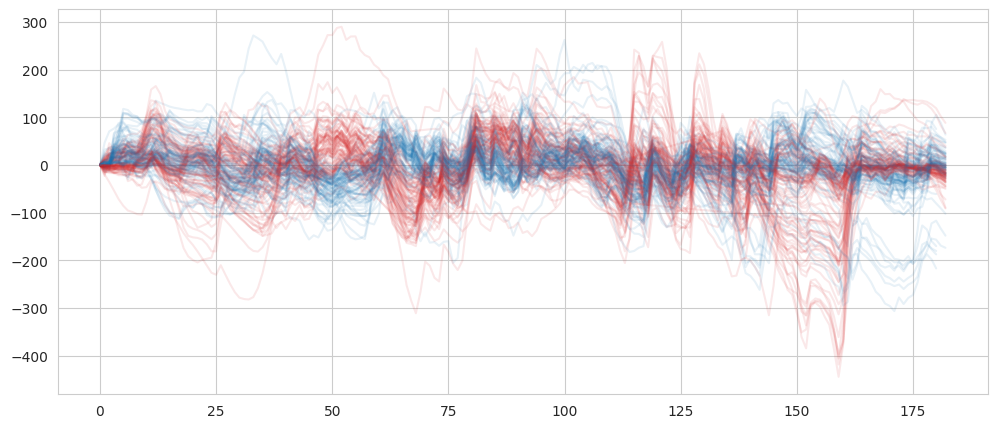

In [5]:
plt.figure(figsize=(12,5))

for i, tree in enumerate(dendro.dendroNr.unique()):
    #plt.scatter(dendro[dendro.dendroNr.eq(tree)].DOY, dendro[dendro.dendroNr.eq(tree)].deltagrowth, c = f"C{1 if '2012' in tree else 2}", alpha=.1)
    plt.plot(dendro[dendro.dendroNr.eq(tree)].DOY, dendro[dendro.dendroNr.eq(tree)].deltagrowth,
             c = f"C{0 if '2012' in tree else 3}", alpha=.1)

plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

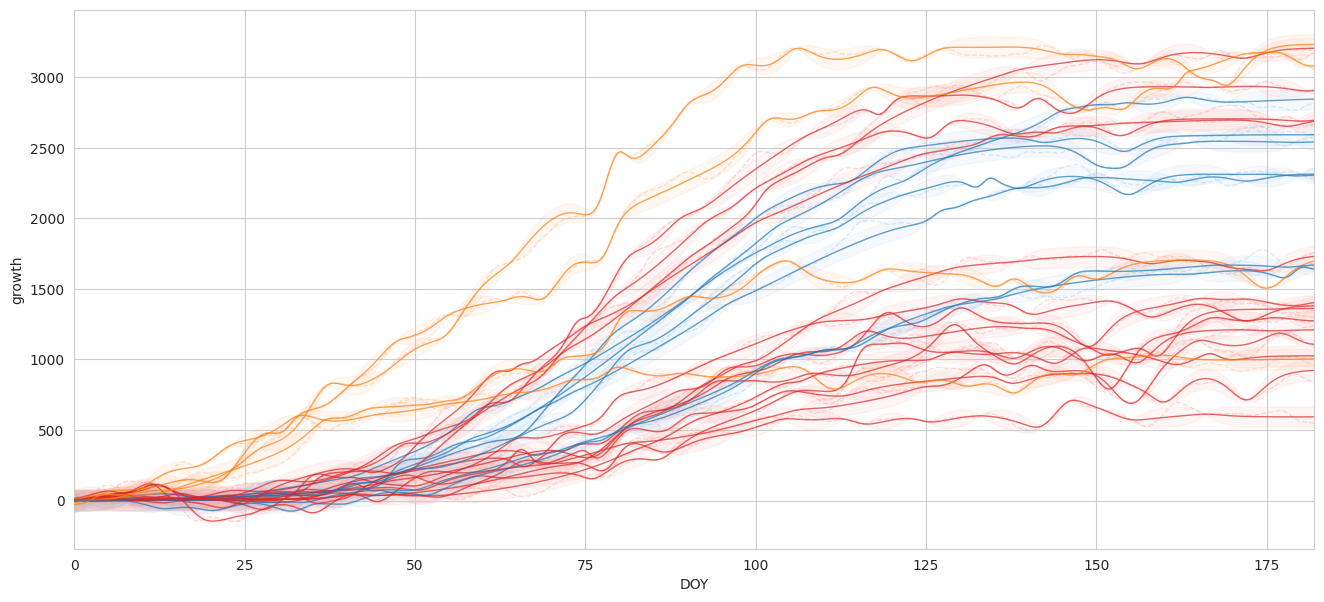

In [7]:
#tree = 'SH_076_2013'

plt.figure(figsize=(16, 7))

rng = np.random.default_rng()

X_test = np.linspace(0, dendro.DOY.max(), 500).reshape(-1, 1)

c = lambda s : 0 if s == "Beech" else (3 if s == "Sycamore" else 1)

for tree in tqdm(dendro.dendroNr.unique()[:25]):
    df_ = dendro.loc[dendro.dendroNr.eq(tree)]

    idx_train = np.sort(rng.integers(0, len(df_.DOY) - 1, 30))

    X_train = df_.DOY.iloc[idx_train].array.reshape(-1, 1)
    y_train = df_.deltagrowth.iloc[idx_train]

    kernel_ = 37**2 * Matern(length_scale=3, length_scale_bounds=(2,16), nu = 2.5) + WhiteKernel(noise_level=.01, noise_level_bounds="fixed")
    gp_model = gaussian_process.GaussianProcessRegressor(
        kernel=kernel_,
        #n_restarts_optimizer=2,
        #normalize_y=True,
        optimizer=None
    )

    gp_model.fit(X_train, y_train)
    mean_pred, std_pred = gp_model.predict(X_test, True)
    y_samples = gp_model.sample_y(X_test, 1)

    weibull_pred = weibull_params[tree][0] * weibull_F(X_test.ravel(), *weibull_params[tree][1:3])

    plt.plot(X_test, mean_pred + weibull_pred, lw=1, zorder=10, alpha = .7, c=sns.color_palette()[c(df_.species.iloc[0])])

    #plt.plot(df_.DOY, df_.growth, lw=1, zorder=10, alpha = .5, c=sns.color_palette("pastel")[c(df_.species.iloc[0])])

    plt.fill_between(
        X_test.ravel(),
        mean_pred + weibull_pred - 1.96 * std_pred,
        mean_pred + weibull_pred + 1.96 * std_pred,
        alpha=.1, zorder=0, color=sns.color_palette("pastel")[c(df_.species.iloc[0])]
    )

    for idx, single_prior in enumerate(y_samples.T):
        plt.plot(
            X_test, single_prior + weibull_pred
            , alpha=.4, lw=1, linestyle="dashed", c=sns.color_palette("pastel")[c(df_.species.iloc[0])]
        )

plt.xlabel("DOY")
plt.ylabel("growth")
plt.xlim(0, dendro.DOY.max())
plt.show()

# SPARSE

In [9]:
import jax
import jax.numpy as jnp

In [8]:
%%capture
# Import my GP
%run ../GP.ipynb

  0%|          | 0/25 [00:00<?, ?it/s]

NMLL: 126.04558950335195
NMLL: 138.4213079874443
NMLL: 142.17735696326608
NMLL: 175.90620139049227
NMLL: 161.4157279056547
NMLL: 229.75489808572078
NMLL: 137.04230368366925
NMLL: 240.91391563504834
NMLL: 153.24090850612947
NMLL: 219.8944617878353
NMLL: 127.43974202871394
NMLL: 146.10447899645564
NMLL: 126.32476549116284
NMLL: 184.34731958590115
NMLL: 120.16775068934952
NMLL: 150.8437298988943
NMLL: 148.83758263100648
NMLL: 156.34944421255298
NMLL: 133.92477167235262
NMLL: 174.74292350733515
NMLL: 274.4268951140756
NMLL: 260.36644949174627
NMLL: 254.9066356552581
NMLL: 206.83596433669513
NMLL: 133.52739512244403


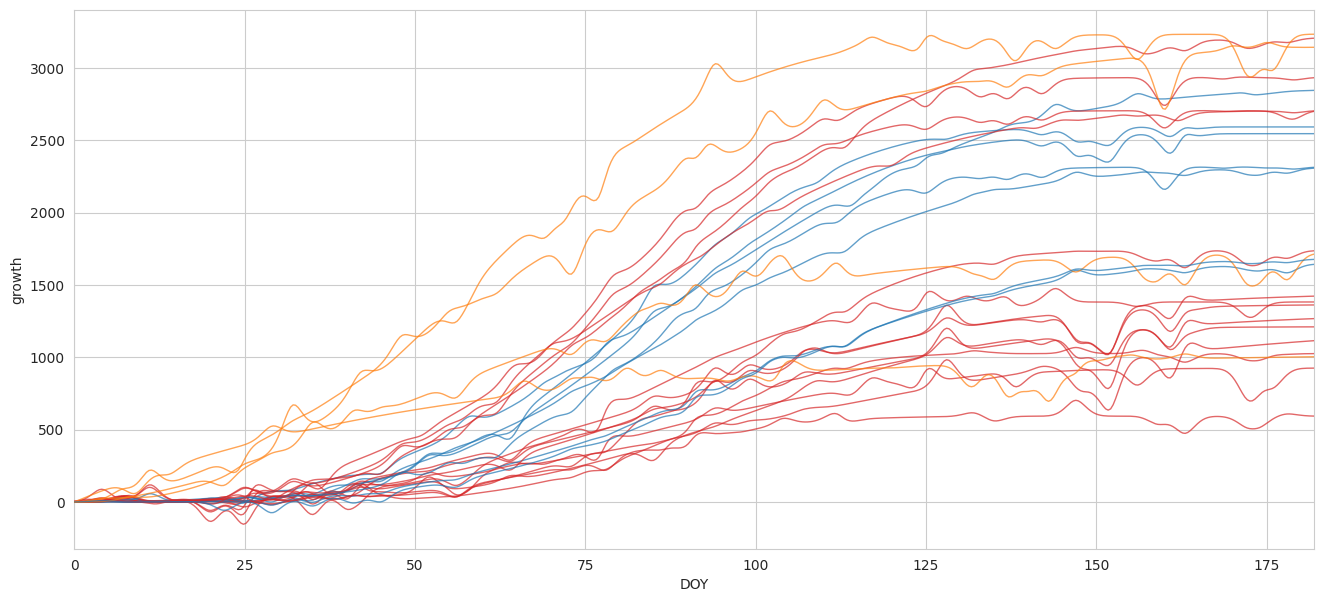

In [28]:
plt.figure(figsize=(16, 7))

X_test = jnp.linspace(0, dendro.DOY.max(), 500).reshape(-1, 1)

c = lambda s : 0 if s == "Beech" else (3 if s == "Sycamore" else 1)

for tree in tqdm(dendro.dendroNr.unique()[:25]):
    df_ = dendro.loc[dendro.dendroNr.eq(tree)]

    #idx_train = jnp.sort(rng.integers(0, len(df_.DOY) - 1, 30))
    idx_train = jnp.sort(jax.random.randint(jax.random.PRNGKey(0), (30,), 0, len(df_.DOY) - 1))
    X_train = jnp.array(df_.DOY.iloc[idx_train].array).reshape(-1, 1)
    y_train = jnp.array(df_.deltagrowth.iloc[idx_train].array)

    # kernel_ = 37**2 * Matern(length_scale=3, length_scale_bounds=(2,16), nu = 2.5) + WhiteKernel(noise_level=.01, noise_level_bounds="fixed")
    # gp_model = gaussian_process.GaussianProcessRegressor(
    #     kernel=kernel_,
    #     #n_restarts_optimizer=2,
    #     #normalize_y=True,
    #     #optimizer=None
    # )
    def kernel_(s, l, x, y):
        #37**2 * Matern(length_scale=3, length_scale_bounds=(2,16), nu = 2.5) + WhiteKernel(noise_level=.01, noise_level_bounds="fixed")
        return MaternKernel32(s, l, x, y) * WendlandTapering(3, 8, x, y)
    gp_model = GPR(X_train, y_train, kernel_, jnp.array([37**2, 3]), eps = 0.01)
    #gp_model.fit(X_train, y_train)
    mean_pred = gp_model.predict(X_test, False)

    weibull_pred = weibull_params[tree][0] * weibull_F(X_test.ravel(), *weibull_params[tree][1:3])

    plt.plot(X_test, mean_pred + weibull_pred, lw=1, zorder=10, alpha = .7, c=sns.color_palette()[c(df_.species.iloc[0])])

    #plt.plot(df_.DOY, df_.growth, lw=1, zorder=10, alpha = .5, c=sns.color_palette("pastel")[c(df_.species.iloc[0])])

    # plt.fill_between(
    #     X_test.ravel(),
    #     mean_pred + weibull_pred - 1.96 * std_pred,
    #     mean_pred + weibull_pred + 1.96 * std_pred,
    #     alpha=.1, zorder=0, color=sns.color_palette("pastel")[c(df_.species.iloc[0])]
    # )

plt.xlabel("DOY")
plt.ylabel("growth")
plt.xlim(0, dendro.DOY.max())
plt.show()